# Modified MINE

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
import math
import time
import sys
from numpy import pi,exp,sin,cos,sqrt,abs,log
from tqdm.notebook import tqdm
#%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [4]:
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.4.1
Num GPUs Available:  1


In [5]:
class FCNN(tf.Module): # fully-connected ReLU net
    def __init__(self, dims, last_activation=None):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation=last_activation)) 
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def reset_weights(model): # https://github.com/keras-team/keras/issues/341
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))

# Conventional Divergence Estimation

In [6]:
def DKL_est(X, Y): 
    """
    Estimates D(P||Q) based on Algorithm A from [Wang et al., 2005]
        X: vector of samples from P with length n
        Y: vector of samples from Q with length m
    """
    n = X.shape[0]
    m = Y.shape[0]
    lm = int(np.floor(sqrt(m)))
    Tm = int(np.floor(m/lm))
    
    Y = np.sort(Y)
    bins = Y[lm-1:lm*(Tm-1):lm]
    bins = np.hstack([-np.inf, bins, +np.inf])
    k,_ = np.histogram(X, bins=bins) # non-uniform bin widths; [b0 b1); [b1 b2); ...; [bn-1; bn]

    Dest = 0
    for i in range(Tm-1):
        if k[i] != 0:
            tmp = (k[i]/n)*log((k[i]/n)/(lm/m))
            Dest = Dest + tmp
            
    delta_m = (m-lm*Tm)
    if k[Tm-1] != 0:
        tmp = (k[Tm-1]/n)*log((k[Tm-1]/n)/(lm/m+delta_m))
    else:
        tmp = 0 
    return Dest + tmp

In [7]:
# compare with library function
from universal_divergence import estimate

n = 100000
X = np.random.gamma(1, 1, size=[n])
Y = np.random.normal(2.5, 2, size=[n])

Dest = DKL_est(X,Y)
print(Dest)
Dest4 = estimate(X[:,np.newaxis],Y[:,np.newaxis], k=1) # slow
print(Dest4)

0.9953474347727509
1.0113280142052392


# modified MINE (with additional input)

In [8]:
class MINE_mod(tf.Module):
    """
        estimates D(P||Q), where P, Q are defined on R^d 
        - MI(X;Y) if P=f_XY and Q=f_X*f_Y
        - d = dim(X) + dim(Y)
        statistics network can take additional input x
    """
    def __init__(self, dims):
        super().__init__()
        self.T = FCNN(dims) # statistics network T, input shape [B, d]
        
    def __call__(self, x_P, x_Q, x=None, averages=1): # E_P[T] - log(E_Q[e^T])
        """
            input shapes: [B, d]
            averages: number of separate averages (must be divisible by B)
        """
        if x is not None:
            if x.shape[0] % averages != 0: raise ValueError("batch size must be divisible by the number of averages")
            T1 = self.T(tf.concat([x, x_P], axis=1)) # [B, 1]
            T2 = self.T(tf.concat([x, x_Q], axis=1)) # [B, 1]
        else:
            if averages != 1: raise ValueError("number of averages should be 1 if no additional input is given")
            T1 = self.T(x_P)
            T2 = self.T(x_Q)
        
        axis_avg = 0
        if averages != 1: # returns shape [averages,]
            T1 = tf.reshape(T1, (averages, -1))
            T2 = tf.reshape(T2, (averages, -1))
            axis_avg = 1
            
        #epsilon = 1e-20 # to avoid log(0) = -Inf
        epsilon = 0
        T2 = tf.clip_by_value(T2, -1e50, 75.0) # this gets rid of the NaNs but leads to other numerical issues (growing loss function)
        
        tmp = tf.reduce_mean(tf.math.exp(T2), axis=axis_avg)
        
        """
        if ((tf.math.is_nan(tmp)).numpy()).any():
            print(tf.reduce_max(T2))
            print(tmp)
            print('NaN detected')
        if ((tf.math.is_inf(tmp)).numpy()).any():
            print(tf.reduce_max(T2))
            print(tmp)
            print('Inf detected')
        """
        #tmp = tf.clip_by_value(tmp, 0, 1e20)
        D_est = (tf.reduce_mean(T1, axis=axis_avg)-tf.math.log(epsilon+tmp)) #/tf.math.log(2.0)
        
        #D_est = (tf.reduce_mean(T1, axis=axis_avg)-tf.math.log(epsilon+tf.reduce_mean(tf.math.exp(T2), axis=axis_avg))) #/tf.math.log(2.0)
        return D_est

In [9]:
@tf.function
def train_MINE_mod(x_P, x_Q, x):
    with tf.GradientTape() as tape:
        loss = -mine(x_P, x_Q, x)
        
    grads = tape.gradient(loss, mine.trainable_variables)
    optimizer.apply_gradients(zip(grads, mine.trainable_variables)) # weighted averaging -> TBD
    return loss

In [10]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
iterations = 500
B = 2000

M = 11
dm = np.linspace(-1,1,M)

n_hidden= 50
dims = [1, n_hidden,n_hidden, 1] 
mine = MINE_mod(dims)

loss_sv = []
for i in tqdm(range(1, iterations+1)):
    tmp = [tf.random.normal([B, 1], j, 1) for j in dm]
    x_P = tf.concat(tmp, axis=0)
    x_Q = tf.random.normal([B*M, 1], 1, 2)
    x = tf.repeat(dm.astype(np.float32), B)[:, tf.newaxis]
    
    loss = -train_MINE_mod(x_P, x_Q, x)
    loss_sv.append(loss)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-31 10:42:21.654512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 10:42:21.656283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-31 10:42:21.656317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-31 10:42:21.656349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-31 10:42:21.656362: I tensorflow/stream_executor/

In [12]:
M_exact = 30
dm_exact = np.linspace(-1,1,M_exact)

Dest_exact = np.zeros([M_exact])
n = int(1e7)
for i in tqdm(range(M_exact)):
    X = np.random.normal(dm_exact[i], 1, size=[n])
    Y = np.random.normal(1, 2, size=[n])
    Dest_exact[i] = DKL_est(X, Y) 

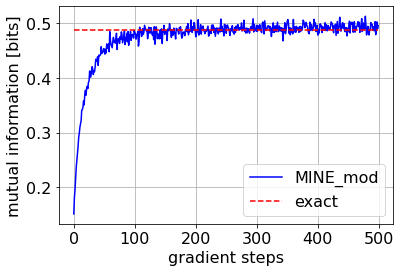

In [13]:
plt.plot(loss_sv, 'b-', label='MINE_mod')
plt.plot(np.mean(Dest_exact)*np.ones(iterations), 'r--', label='exact')
plt.xlabel('gradient steps'), plt.ylabel('mutual information [bits]')
plt.legend()
plt.grid()
plt.show()

In [14]:
# testing on the same x's as used for training
Dest_train = np.zeros([M])
n = int(1e7)

for i in tqdm(range(M)):
    x_P = tf.random.normal([n, 1], dm[i], 1)
    x_Q = tf.random.normal([n, 1], 1, 2)
    x = dm[i]*tf.ones([n,1])
    Dest_train[i] = mine(x_P, x_Q, x)
    
# testing on different x's
M_eval = 10
dm_eval = np.linspace(-0.9,0.9,M_eval)

Dest_eval = np.zeros([M_eval])
n = int(1e7)

for i in tqdm(range(M_eval)):
    x_P = tf.random.normal([n, 1], dm_eval[i], 1)
    x_Q = tf.random.normal([n, 1], 1, 2)
    x = dm_eval[i]*tf.ones([n,1])
    Dest_eval[i] = mine(x_P, x_Q, x)

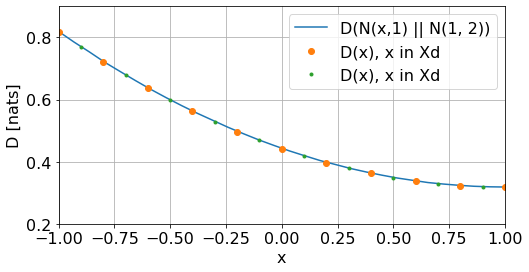

In [15]:
fig = plt.figure(figsize=(8, 4))
plt.plot(dm_exact, Dest_exact, label='D(N(x,1) || N(1, 2))')
plt.plot(dm, Dest_train, linestyle='none', marker='o', label='D(x), x in Xd')
plt.plot(dm_eval, Dest_eval, linestyle='none', marker='.', label='D(x), x in Xd')
plt.legend()
plt.xlabel('x'), plt.ylabel('D [nats]'), plt.grid()
plt.xlim(-1.0, 1.0)
plt.ylim(0.2, 0.9)
plt.show()